<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Parallel_Sync_CNN_Research_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel Synchronous Gradient Descent CNN Research
In this notebook, I am led by graduate student Pengzhan Guo to create a synchronous CNN that can be parallelized between multiple supercomputers and is optimized by the best gradient descent networks (ADAM or RMSProp).

A sample run of the CNN will be completed with the CIFAR10 dataset and that framework will be applied here as well. The network will be based on the <a href="https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py" target="_blank">VGG16 design</a> that was proposed by K. Simonyan and A. Zisserman. 

How else could you create a custom CNN?

In [1]:
!pip3 install keras-tuner

     |████████████████████████████████| 61kB 2.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=fe6843ebe8e9e3e3faca1520e8ad819a3f18770ea31c79ce513841867f8eb6a5
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=8bdd0f11b1032575888bbccfa83b6ad3e5cd10490724868a8587566c6651d1db
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from PIL.Image import ANTIALIAS


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.python.client import device_lib
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters

import random
import tarfile
import zipfile
import os
import concurrent.futures

from os.path import exists
from warnings import simplefilter

Since Keras has not updated alongside Pandas to note this warning noting users to do this,
```
df[index] --> df.iloc[index]
```
there will be a bunch of warnings while training the CNN. Let's remove it.



In [3]:
simplefilter(action='ignore', category=FutureWarning)

# Setting Up Google Drive
This will be used later to save the model before the runtime disconnects.

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Retrieving the Datasets

First, I am getting the version of `TF Keras`, TF 2.0 makes the creation of neural networks a lot easier. 

The devices variable will make finding all CPUs and GPUs in the computer easier.

In [5]:
# DEBUG
print(tf.keras.__version__)
devices = device_lib.list_local_devices()

2.4.0


## Using The Image Data
This is from mammographic slides with SVS images rather than DICOM images

The strategy:
1. To identify breast cancer cells, you need to convert them from the slide data to standard jpeg images. It would also be a good idea to resize them to a reasonable size (300 x 300)
2. In order to do this, you can read the zip file and use `concurrent.futures` to read the data async while other things are running.
3. Finally, it is preprocessing time!

Side Note: How do I save the images without using too much storage? (Many gigabytes and megabytes x 140)

In [7]:
output_folders = []

for folder in os.listdir("."):
    full_path: str = os.path.join(os.getcwd(), folder)  
    if folder.endswith(".zip"):
        with zipfile.ZipFile(full_path) as zf:
            name = full_path.replace(".zip", "")
            zf.extractall(name)
    elif folder.endswith(".tar.gz"):
        with tarfile.open(full_path) as tf:
            name = full_path.replace(".tar.gz", "")
            print(name)
            output_folders.append(name)
            tf.extractall(name)

/content/Output5
/content/Output7
/content/Output2
/content/Output6
/content/Output3
/content/Output4
/content/Output1


In [8]:
import shutil

# Total Number of Files: 150 (Sample)

outputs_path = os.path.join(os.getcwd(), "outputs")

if not os.path.exists(outputs_path):
  # shutil.rmtree(outputs_path)
  os.mkdir(outputs_path)

pic_directory = []

for subfolder in output_folders:
  for pic_dir in os.listdir(subfolder):
      pic_directory.append(os.path.join(subfolder, pic_dir))

# print(pic_directory)
# for output in pic_directory:
#   print(len(os.listdir(output)))
print(pic_directory)

for output in pic_directory:
  for file in os.listdir(output):
    print(os.path.join(outputs_path, file))
    shutil.move(os.path.join(output, file), os.path.join(outputs_path, file))


['/content/Output5/Output', '/content/Output7/Output', '/content/Output2/Output', '/content/Output6/Output', '/content/Output3/Output', '/content/Output4/Output', '/content/Output1/Output']
/content/outputs/HobI17-435966474961.png
/content/outputs/HobI17-440719796933.png
/content/outputs/HobI17-313879325559.png
/content/outputs/HobI17-269154319884.png
/content/outputs/HobI17-553581330459.png
/content/outputs/HobI17-425397955012.png
/content/outputs/HobI17-324909994030.png
/content/outputs/HobI17-288509838143.png
/content/outputs/HobI17-458471686651.png
/content/outputs/HobI17-348600370849.png
/content/outputs/HobI17-334708419649.png
/content/outputs/HobI17-495667251867.png
/content/outputs/HobI17-265070624026.png
/content/outputs/HobI17-447409697483.png
/content/outputs/HobI17-467062691081.png
/content/outputs/HobI17-519774790910.png
/content/outputs/HobI17-421574798660.png
/content/outputs/HobI17-545903287930.png
/content/outputs/HobI17-377050210278.png
/content/outputs/HobI17-4760549

## Parallelzing the I/O for Reading Images!

So now we are going to read the images and get each of their filenames. In actuality, we will need to use `pydicom` later to transform the actual svs images into PNG or JPEG.

In [9]:
# choose the best size
size = (256, 256)

def read_images(directory: str) -> np.ndarray:
  # print(directory)
  print([os.path.join(directory, img) for img in os.listdir(directory) 
  if img.endswith(".png") or img.endswith(".jpg")])

  imgs = [load_img(os.path.join(directory, img)) for img in sorted(os.listdir(directory)) 
  if img.endswith(".png") or img.endswith(".jpg")]
  # print(imgs)
  thumbnails = [img.resize(size, ANTIALIAS) for img in imgs]

  # FOR THUMBNAILS (LARGE IMAGES)
  # [img.thumbnail(size, ANTIALIAS) for img in imgs]
  # thumbnails = [img for img in imgs]
  # print(thumbnails)

  # PUT SOMEWHERE ELSE --> arrays = [img_to_array(img) for img in thumbnails]
  return thumbnails

Parallelizing I/O, here we go!

['/content/outputs/HobI17-219470745199.png', '/content/outputs/HobI18-104537363663.png', '/content/outputs/HobI17-435966474961.png', '/content/outputs/HobI18-615488176850.png', '/content/outputs/HobI17-085745661307.png', '/content/outputs/HobI17-883321793262.png', '/content/outputs/HobI16-800515347962.png', '/content/outputs/HobI18-116913530563.png', '/content/outputs/HobI18-423802432924.png', '/content/outputs/HobI16-673050001795.png', '/content/outputs/HobI16-303757967057.png', '/content/outputs/HobI18-295854571047.png', '/content/outputs/HobI18-585178062343.png', '/content/outputs/HobI17-796855272934.png', '/content/outputs/HobI18-156692134456.png', '/content/outputs/HobI17-440719796933.png', '/content/outputs/HobI17-313879325559.png', '/content/outputs/HobI17-890038662634.png', '/content/outputs/HobI17-269154319884.png', '/content/outputs/HobI17-553581330459.png', '/content/outputs/HobI17-640264021539.png', '/content/outputs/HobI17-425397955012.png', '/content/outputs/HobI17-788882

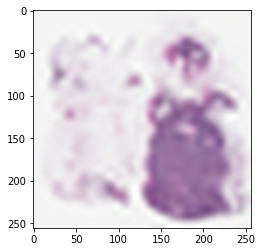

In [10]:
# read in fixed order

bc_images = read_images(outputs_path)
plt.imshow(bc_images[0])

### Aligning the dataframe with the resized pictures

This first part is an assertion to find out the number of images in the folder so that it matches with the target `DataFrame`.

In [11]:
print(len(os.listdir(outputs_path)))

130


*Now*, we can sort the images and filenames (in order) by zipping them and then add it to the dataframe

In [12]:
import pandas as pd

df = pd.read_csv('target.csv')

df['slide'] = df['slide'].str.replace(".svs", ".jpg")
df = df.sort_values('slide') # just in case

df

,slide,target
0,HobI16-053768896760.jpg,1
1,HobI16-072823783181.jpg,1
2,HobI16-105105202254.jpg,0
3,HobI16-303757967057.jpg,0
4,HobI16-334188031493.jpg,0
...,...,...
125,HobI18-711038761484.jpg,0
126,HobI18-767451561893.jpg,0
127,HobI18-789815111269.jpg,1
128,HobI18-796881418672.jpg,0


Since I do not employ parallelism and I read the images in order, I do not need to sort the images for the dataframe. Thus, `df[slide]` are the names of the images and `bc_images` are the images (PILLOW).

In [13]:
combined = list(zip(bc_images, df['slide'].values))
print(combined)

sorted_images = [img_pair[0] for img_pair in combined]

df['imgs'] = sorted_images

[(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488E9DD8>, 'HobI16-053768896760.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488E9E48>, 'HobI16-072823783181.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488E9EB8>, 'HobI16-105105202254.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488E9F28>, 'HobI16-303757967057.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488E9F98>, 'HobI16-334188031493.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488F1048>, 'HobI16-553454144783.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488F10B8>, 'HobI16-568713100973.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488F1128>, 'HobI16-673050001795.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488F1198>, 'HobI16-708082515907.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488F1208>, 'HobI16-723628532151.jpg'), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FA5488F

Because this is in order, the dataframe now contains all of the images!!

In [14]:
df.head()

,slide,target,imgs
0,HobI16-053768896760.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
1,HobI16-072823783181.jpg,1,<PIL.Image.Image image mode=RGB size=256x256 a...
2,HobI16-105105202254.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
3,HobI16-303757967057.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...
4,HobI16-334188031493.jpg,0,<PIL.Image.Image image mode=RGB size=256x256 a...


Tada, now we have all the images and labels sorted! 

We can now do any of the preprocessing we want with the sorted images!

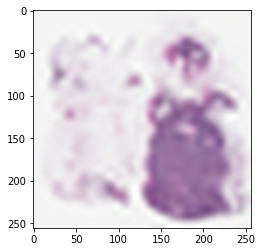

In [15]:
# Assertion
plt.imshow(df['imgs'][0])

## Examining Class Imbalance

Could show this in two ways. The first will be through a standard **histogram** and then I will configure a **pie chart** for a prettier view!

Text(0, 0.5, 'Frequency')

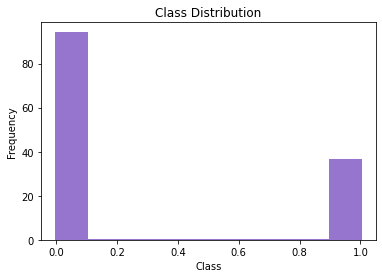

In [16]:
# Histogram
plt.hist(df['target'].values, histtype='step', fill=True, color='#9575cd', linewidth=3)
plt.title("Class Distribution")
plt.xlabel('Class')
plt.ylabel('Frequency')

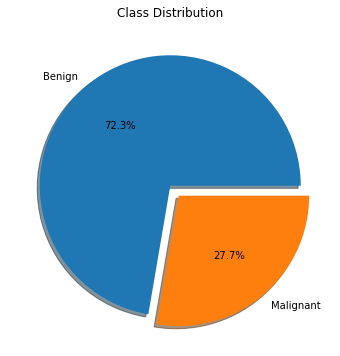

In [17]:
explode = (0, 0.1)

plt.pie(df['target'].value_counts(), labels=['Benign', 'Malignant'], 
        shadow=True, explode=explode, autopct='%1.1f%%')
plt.title("Class Distribution")

fig = plt.gcf()
fig.set_size_inches(6, 6)

In [18]:
benign = len(df['target'][df['target'] == 0]) # benign is 0
malignant = len(df['target'][df['target'] == 1]) # malignant is 1
total = benign + malignant

print(f"Benign Samples: {benign} ({round(benign / total, 3) * 100}% of total)")
print(f"Malignant Samples: {malignant} ({round(malignant / total, 3) * 100}% of total)")

weight_benign = (1 / benign) * (total) / 2.0
weight_malignant = (1 / malignant) * (total) / 2.0

class_weights = {0: weight_benign, 1: weight_malignant}

print()
print(f"Weight for class 0 [benign]: {round(weight_benign, 3)}")
print(f"Weight for class 1 [malignant]: {round(weight_malignant, 3)}")

Benign Samples: 94 (72.3% of total)
Malignant Samples: 36 (27.700000000000003% of total)

Weight for class 0 [benign]: 0.691
Weight for class 1 [malignant]: 1.806


Now, we can shuffle and split the data using `train_test_split` from scikit-learn

In [55]:
xi_train, xi_test, y_train, y_test = train_test_split(df['imgs'], 
                                                    df['target'], random_state=42, stratify=df['target'])

print(xi_train.head())
print(y_train.head())

78    <PIL.Image.Image image mode=RGB size=256x256 a...
21    <PIL.Image.Image image mode=RGB size=256x256 a...
6     <PIL.Image.Image image mode=RGB size=256x256 a...
36    <PIL.Image.Image image mode=RGB size=256x256 a...
49    <PIL.Image.Image image mode=RGB size=256x256 a...
Name: imgs, dtype: object
78    1
21    0
6     0
36    0
49    0
Name: target, dtype: int64


# Preprocessing the Data

In [56]:
def normalize_train(train_vec: np.ndarray):
  """ Normalizes the data by dividing by subtracting the mean 
      and dividing by the standard deviation. Akin to scikit-learn's
      StandardScaler."""
  mean_train = np.mean(train_vec)
  std_train = np.std(train_vec)
  return (train_vec - mean_train) / std_train

Before we apply preprocessing to the data, we need to transform all of the PIL images into arrays of pixel intensities.

In [57]:
xl_train = []
for i in xi_train:
  xl_train.append(img_to_array(i))

xl_test = []
for i in xi_test:
  xl_test.append(img_to_array(i))

x_train, x_test = np.array(xl_train), np.array(xl_test)


print(f"X TRAIN: {x_train[:2]} \n\n")
print(f"Y TRAIN: {x_test[:2]}")

print(x_train.shape)

X TRAIN: [[[[242. 242. 243.]
   [242. 242. 243.]
   [242. 242. 243.]
   ...
   [241. 240. 241.]
   [241. 240. 241.]
   [241. 240. 241.]]

  [[242. 242. 243.]
   [242. 242. 243.]
   [242. 242. 243.]
   ...
   [241. 240. 241.]
   [241. 240. 241.]
   [241. 240. 241.]]

  [[242. 242. 243.]
   [242. 242. 243.]
   [242. 242. 243.]
   ...
   [241. 240. 241.]
   [241. 240. 241.]
   [241. 240. 241.]]

  ...

  [[242. 242. 242.]
   [242. 242. 242.]
   [242. 242. 242.]
   ...
   [237. 237. 238.]
   [237. 237. 238.]
   [237. 237. 238.]]

  [[242. 242. 242.]
   [242. 242. 242.]
   [242. 242. 242.]
   ...
   [237. 237. 238.]
   [237. 237. 238.]
   [237. 237. 238.]]

  [[242. 242. 242.]
   [242. 242. 242.]
   [242. 242. 242.]
   ...
   [237. 237. 238.]
   [237. 237. 238.]
   [237. 237. 238.]]]


 [[[242. 244. 241.]
   [242. 244. 241.]
   [242. 244. 241.]
   ...
   [241. 244. 241.]
   [241. 244. 241.]
   [241. 244. 241.]]

  [[242. 244. 241.]
   [242. 244. 241.]
   [242. 244. 241.]
   ...
   [241. 244

### Visualizing the Data

I am going to look at a couple of the data points before normalization

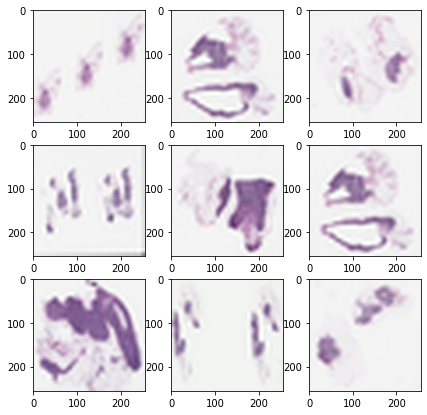

In [58]:
from random import choice

def visualize_cifar(train_data):
  """ Visualizes the cifar-10 dataset using matplotlib. This helps give a greater understanding
      of the items that are in the dataset"""
  plt.figure(figsize=(7, 7))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(choice(train_data) / 255)

# if CIFAR
visualize_cifar(x_train)

### Back to Preprocessing

And now, we prepare the data for preprocessing!

*   As of the last code cell, the training vectors **X** are already converted to `ndarrays` and normalized by dividing by the mean and standard deviation (StandardScaler a la `scikit-learn`.
* Now, we just need to add a data generator to increase the amount of train data we have



In [59]:
x_train, x_test = normalize_train(x_train), normalize_train(x_test)

print(f"X TRAIN: {x_train[0]} \n\n")
print(f"Y TRAIN: {x_test[0]}")


X TRAIN: [[[0.49162948 0.49162948 0.51899815]
  [0.49162948 0.49162948 0.51899815]
  [0.49162948 0.49162948 0.51899815]
  ...
  [0.46426085 0.4368922  0.46426085]
  [0.46426085 0.4368922  0.46426085]
  [0.46426085 0.4368922  0.46426085]]

 [[0.49162948 0.49162948 0.51899815]
  [0.49162948 0.49162948 0.51899815]
  [0.49162948 0.49162948 0.51899815]
  ...
  [0.46426085 0.4368922  0.46426085]
  [0.46426085 0.4368922  0.46426085]
  [0.46426085 0.4368922  0.46426085]]

 [[0.49162948 0.49162948 0.51899815]
  [0.49162948 0.49162948 0.51899815]
  [0.49162948 0.49162948 0.51899815]
  ...
  [0.46426085 0.4368922  0.46426085]
  [0.46426085 0.4368922  0.46426085]
  [0.46426085 0.4368922  0.46426085]]

 ...

 [[0.49162948 0.49162948 0.49162948]
  [0.49162948 0.49162948 0.49162948]
  [0.49162948 0.49162948 0.49162948]
  ...
  [0.35478628 0.35478628 0.3821549 ]
  [0.35478628 0.35478628 0.3821549 ]
  [0.35478628 0.35478628 0.3821549 ]]

 [[0.49162948 0.49162948 0.49162948]
  [0.49162948 0.49162948 0.4

In [61]:
NUM_CLASSES = 1
BATCH_SIZE = 128

print(x_train.shape)
# x_train = x_train.astype("float32")
# x_test = x_test.astype("float32")

# Preprocessing the image dataset by artificially increasing the training data size
# via rescaling, shifting, flipping and rotating the dataset.
data_gen = ImageDataGenerator(
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

data_gen.fit(x_train)

(97, 256, 256, 3)


# Building The Model
The models were built by using a combination of methods from the Inceptionv3 model and the VGGNet models that are on Github. The layers used are given in the imports in the first code cell.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv2D, Activation

In [62]:
def cancer_tunable(hp, output_bias=None):
    model = tf.keras.models.Sequential()

    reg_factor = hp.Choice('regularization', [1e-5, 1e-6, 1e-7])
    default_filter = 64
    NUM_CLASSES = 10

    if output_bias is not None:
      output_constant = tf.keras.initializers.Constant(output_bias)
      # Layer 1
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter1', min_value=16, 
                                            max_value=256, step=16), (3, 3), 
                                      kernel_initializer=tf.keras.initializers.he_normal(), 
                                    input_shape=(32, 32, 3),
    padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-2', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", 
                                      kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling2D(2, 2))

      # Layer 2
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-3', min_value=16, 
                                            max_value=256, step=16), (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-4', min_value=16, 
                                            max_value=256, step=16), 1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-4b', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_val-1', min_value=0.2, max_value=0.45, step=0.05)))

    # Layer 3
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-5', min_value=16, 
                                            max_value=256, step=16), (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-6', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.MaxPooling2D(2, 2))

    # Layer 4
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-7', min_value=16, 
                                            max_value=256, step=16), (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-8', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling2D(2, 2))


    # Layer 5
    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-9', min_value=16, 
                                            max_value=256, step=16), (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(hp.Int(f'filter-10', min_value=16, 
                                            max_value=256, step=16), (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.MaxPooling2D(1, 1))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_val-2', min_value=0.2, max_value=0.49, step=0.05)))


    # END OF CONVOLUTIONS - HERE LIES DENSE FLATTENING!

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Int('dense-1', min_value=16, max_value=90, step=8) * 64, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(hp.Int('dense-2', min_value=16, max_value=90, step=8) * 64, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(NUM_CLASSES, bias_initializer=output_constant))
    model.add(tf.keras.layers.Activation('softmax'))

    optimizer = SGD(lr=hp.Choice('lr', [1e-5, 1e-3, 5e-4]), momentum=0.9, nesterov=True)


  # COMPILING THE MODEL!
    model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC()])

    return model

## Getting The Best Hyperparameters

In this block, we are going to create a hyperparameter tuner with the help of **keras-tuner** to find the best hyperparameters for this problem. The second code block is how you can tune how often the tuner runs.

**Why is there an output bias with a natural log factor? See [this](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias) link for more info.**

Essentially setting the bias correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias. (Paraphrased from [Andrej Karpathy Blog](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines) )


---




The correct bias has the formula$\ b_0 = \log(\frac{p}{n})$ where$\ b_0$ is the last output layer's bias,$\ p$ is the quantity of the smaller class and$\ n$ is the quantity of the larger class.

The default bias without output bias initialization is$\ \log(2) \approx 0.69314$.

In [64]:
output_bias = np.log([malignant / benign])
print(output_bias)

[-0.95977584]


Now, I am going to set up the auto-tuned hyperparameters for the model.

In [66]:
hp = HyperParameters()
model = cancer_tunable(hp, output_bias)

tf.keras.utils.plot_model(model, 'cancer-vis.png', show_shapes=True)

plt.imshow(Image.open('cancer-vis.png'))

AttributeError: ignored

In [ ]:
tuner = RandomSearch(
    cancer_tunable,
    objective='val_auc',
    max_trials=5,
    executions_per_trial=3,
    directory='test_dir'
)
tuner.search_space_summary()

In [ ]:
callbacks = []
sample_path = os.path.join(os.getcwd(), "kerastunercancer.hdf5")

callbacks.append(tf.keras.callbacks.EarlyStopping('val_auc', verbose=1, 
                                                  patience=50, 
                                                  restore_best_weights=
                                                  True))
callbacks.append(tf.keras.callbacks.ModelCheckpoint(sample_path, 
                                                    monitor='val_auc', 
                                                    save_weights_only=False,
                                                    save_best_only=True, 
                                                    verbose=1, 
                                                    save_freq='epoch'))

Above: Basic callbacks to monitor the progress. Not really needed.

Below: The actual parameter tuning. It will take around 5 hours to tune the model for around 750 epochs. A **large batch size** is required because of the class imbalance so all classes are captured in the mini-batch.

In [ ]:
epochs = 50
BATCH_SIZE = 200

tuner.search(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      epochs=EPOCHS,
                      steps_per_epoch=(len(x_train) // BATCH_SIZE),
                      class_weight=class_weights, 
                      validation_data=(x_test, y_test), callbacks=callbacks)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]

If no hyperparameters saved, load it from the pickle file.

In [ ]:
import pickle

parameter_file = "/content/cancer-hyperparameters.p"

if os.path.exists(parameter_file):
  with open(parameter_file, 'rb') as pk:
    best_hps = pickle.load(pk)

Hyperparameters obtained from the model:

Saved via the *pickle* module.

In [ ]:
trainable = ('regularization', 'filter1', 'filter-2', 'filter-3', 'filter-4', 'filter-4b', 'filter-5', 
             'filter-6', 'filter-7', 'filter-8', 'filter-9', 'filter-10',
             'dropout_val','dropout_val-1', 'dropout_val-2', 'dropout_val-3', 'lr', 'dense-1', 'dense-2')

for search_space in trainable:
  print(f"The best value for the '{search_space}' variable was {best_hps.get(search_space)}")

In [ ]:
import pickle

with open(parameter_file, 'wb') as pk:
  pickle.dump(best_hps, pk)

Now, we print the models to see their summary and number of parameters in each.

In [ ]:
model_path = 'drive/My Drive/Colab Notebooks/best-cancer-model.hdf5'

tf.keras.utils.plot_model(model, 'cancer-vis.png', show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 16)        400       
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 16)         

# Executing the Model
Now, the model built above will be executed with the training set. If there are more than one GPUs on the computer this file is being called in, then it will parallelize the model between the GPUs, else it will execute on the one GPU and CPU. 

In [ ]:
print(tf.keras.__version__)

devices = device_lib.list_local_devices()
gpus = [devices[i].device_type in devices for (i, device) in enumerate(devices) if "GPU" in devices[i].device_type]

isParallel = any(gpus)
print(f"Are there any GPUs I can use? " {isParallel})


2.3.0-tf
[False, False]
25000


Setting up to tune the learning rate.

In [ ]:
%load_ext tensorboard
import tensorflow.keras.backend as K
from datetime import datetime
from tensorflow.keras.models import load_model

In [ ]:
kcallbacks = []
logdir = "logs/scalars/" + datetime.now().strftime("%m%d%y-%H%M%S")
model_path = 'drive/My Drive/Colab Notebooks/bestcancer-tunedmodel.hdf5'
kcallbacks.append(tf.keras.callbacks.ModelCheckpoint(model_path, 
                                                    monitor='val_auc', 
                                                    save_weights_only=False,
                                                    save_best_only=True, 
                                                    verbose=1, 
                                                    save_freq='epoch'))
kcallbacks.append(tf.keras.callbacks.TensorBoard(
    log_dir=logdir))

print(model_path, "\n", logdir)

In [ ]:
if os.path.exists(model_path):
  model = load_model(model_path)
  print(f'[INFO] Current Learning Rate of Model Is: {K.get_value(model.optimizer.lr)}')
  print(f'[INFO] Changing LR to {K.get_value(model.optimizer.lr) / 10}')
  K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) / 10)
  K.set_value(model.optimizer.lr, 5e-2)
  print(f'[INFO] New Learning Rate Is: {K.get_value(model.optimizer.lr)}')
else:
  model = tuner.hypermodel.build(best_hps)
  K.set_value(model.optimizer.lr, model.optimizer.lr * 10**2)
  print(f'[INFO] Current Learning Rate of Model Is: {K.get_value(model.optimizer.lr)}')

Adding the constants and showing the TensorBoard to track progress. I will add a confusion matrix later to adjust any preprocessing I need to improve the model.

In [ ]:
EPOCHS = 300
BATCH_SIZE = 200

history =
print(y_train.shape)


(50000, 1)


In [ ]:
%tensorboard --logdir logs/scalars

In [ ]:
print(model.optimizer.lr)

In [ ]:
if isParallel:
  print('GPUs parallelized!')
  model2 = tf.keras.utils.multi_gpu_model(model, 2)
  history = model2.fit(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test), class_weight=class_weights, 
                      callbacks=kcallbacks)
else:
  print('CPU Compilation')
  history = model.fit(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      epochs=EPOCHS,
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE),
                      class_weight=class_weights, 
                      validation_data=(x_test, y_test), callbacks=kcallbacks)
  model.save(model_path)

CPU Compilation


NameError: ignored

# Analyzing Results
Currently, the best results give a constant validation binary accuracy of .7564.

In [ ]:
main_results = model2.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
for metric, result in zip(model2.metrics_names, main_results):
  print(metric, " : ", result)

1250/1250 [==============================] - 4s 3ms/step - loss: 5.3644e-07 - AUC: 0.5000 - accuracy: 0.1000
loss  :  5.364418598219345e-07
AUC  :  0.5
accuracy  :  0.10000000149011612


In [ ]:
def plot_curve(train_data, test_data, figname, title, ylabel):
  plt.clf()
  plt.plot(train_data)
  plt.plot(test_data)
  plt.xlabel('Epoch')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig(figname)

In [ ]:
plot_curve(history.history['binary_acc'], 
           history.history['val_binary_acc'], 'model2acc.png', 
           'Model Accuracy vs Epoch', 
          'Accuracy')
plot_curve(history.history['loss'], 
           history.history['val_loss'], 'model2loss.png',
           'Model Loss vs Epoch', 'Loss')